In [218]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [219]:
import json
from tqdm import tqdm
from pathlib import Path
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
np.random.seed(42)

In [220]:
# Default paths
ROOT = Path("/content/drive/MyDrive/BDA Project/Amazon_products")
TRAIN_PATH = ROOT / "train"
TEST_PATH = ROOT / "test"

TRAIN_CORPUS_PATH = TRAIN_PATH / "train_corpus.txt"
TEST_CORPUS_PATH = TEST_PATH  / "test_corpus.txt"
CLASSES_PATH = ROOT / "classes.txt"
HIERARCHY_PATH = ROOT / "class_hierarchy.txt"
REL_KEYWORDS_PATH = ROOT / "class_related_keywords.txt"

In [221]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import itertools
from pathlib import Path
import json

# ------------------------
# Function for loads
# ------------------------

def load_lines(p: Path):
    with p.open("r", encoding="utf-8") as f:
        return [line.rstrip("\n") for line in f]

def load_pid2text(p: Path):
    """TSV: pid \\t text  -> dict[pid]=text"""
    pid2text = {}
    with p.open("r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip("\n").split("\t", 1)
            if len(parts) == 2:
                pid, text = parts
                pid2text[pid] = text
    return pid2text

def load_classes_int(p: Path):
    class_dict = {}
    with p.open("r", encoding="utf-8") as f:
        for line in f:
            label_int, label_str = line.rstrip("\n").split("\t")
            class_dict[int(label_int)] = label_str
    return class_dict

def load_classes_str(p: Path):
    class_dict = {}
    with p.open("r", encoding="utf-8") as f:
        for line in f:
            label_int, label_str = line.rstrip("\n").split("\t")
            class_dict[label_str] = int(label_int)
    return class_dict

def load_keywords(p: Path):
    keywords = {}
    with p.open("r", encoding="utf-8") as f:
        for line in f:
            key, items = line.rstrip("\n").split(":")
            item_list = [item for item in items.split(",")]
            keywords[key] = item_list
    return keywords

def load_class_graph(p: Path):
    edges = []
    with p.open("r", encoding="utf-8") as f:
        for line in f:
            p, c = map(int, line.rstrip("\n").split("\t"))
            edges.append((p, c))
    return edges

def load_json(path):
    """Load JSON file into Python object."""
    with open(path) as f:
        return json.load(f)

# ------------------------
# Visualization
# ------------------------

def plot_results(results_dict, split="valid", metric='Accuracy'):
    """
    Plot metric values over epochs for multiple models.

    Args:
        results_dict: dict of dicts.
            Example: results_dict["valid"]["mlp_partial"] = [0.8, 0.82, ...]
        split: "valid" or "test"
        metric: name of the metric to display
    """
    assert split in results_dict, f"{split} not in results_dict"

    plt.figure(figsize=(8, 5))
    for label, acc_list in results_dict[split].items():
        plt.plot(acc_list, label=label)

    plt.title(f"{split.capitalize()} {metric} over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------
# Printing evaluation results
# ------------------------

def print_eval_result(metrics: dict, stage="val", is_improved=False):
    """
    Print evaluation results (accuracy, F1-macro).

    Args:
        metrics: dict with keys 'accuracy' and 'f1_macro'
        stage: string label (e.g., "val", "test")
        is_improved: mark with '*' if results improved
    """
    star = " *" if is_improved else ""
    print(f"[{stage.upper():4}] Acc: {metrics['accuracy']:.4f} | "
          f"F1-macro: {metrics['f1_macro']:.4f}{star}")


def print_eval_result_esci(metrics: dict, stage="val", is_improved=False):
    """
    Print evaluation results including per-class accuracy for ESCI labels.

    Args:
        metrics: dict with 'accuracy', 'f1_macro', and optionally 'per_class_accuracy'
        stage: string label (e.g., "val", "test")
        is_improved: mark with '*' if results improved
    """
    star = " *" if is_improved else ""
    print(f"[{stage.upper():4}] Acc: {metrics['accuracy']:.4f} | "
          f"F1-macro: {metrics['f1_macro']:.4f}{star}")

    # Print per-class accuracy if available
    if "per_class_accuracy" in metrics:
        id2label = {0: "E", 1: "S", 2: "C", 3: "I"}
        per_class_acc_str = [
            f"{id2label[cls_id]}: {acc:.4f}"
            for cls_id, acc in metrics["per_class_accuracy"].items()
        ]
        print("        " + " | ".join(per_class_acc_str))

In [222]:
# ---------- Read-only loads ----------

train_pid2text    = load_pid2text(TRAIN_CORPUS_PATH)
test_pid2text     = load_pid2text(TEST_CORPUS_PATH)
classes_int       = load_classes_int(CLASSES_PATH)
classes_str       = load_classes_str(CLASSES_PATH)
rel_keywords      = load_keywords(REL_KEYWORDS_PATH)
class_graph_edges = load_class_graph(HIERARCHY_PATH)

print(f"#train={len(train_pid2text):,}  #test={len(test_pid2text):,}")

#train=29,487  #test=19,658


## Dataset settings

In [223]:
EMB_PATH = Path("/content/drive/MyDrive/BDA Project/Embeddings3")

train_emb_dict = load_json(EMB_PATH / "train_embeddings.json")
test_emb_dict = load_json(EMB_PATH / "test_embeddings.json")
class_emb_dict = load_json(EMB_PATH / "class_embeddings.json")

In [224]:
train_emb = torch.tensor(list(train_emb_dict.values()))
test_emb = torch.tensor(list(test_emb_dict.values()))
class_emb = torch.tensor(list(class_emb_dict.values()))

train_emb   = F.normalize(train_emb, p=2, dim=1)   # (N, d)
test_emb = F.normalize(test_emb, p=2, dim=1)   # (N', d)
class_emb = F.normalize(class_emb, p=2, dim=1)   # (C, d)

In [225]:
import pandas as pd

SILVER_PATH = Path("/content/drive/MyDrive/BDA Project/outputs") / "(alibaba)path-core-silver.csv"

silver_label = pd.read_csv(SILVER_PATH)
class_num = len(classes_int)

# Build label -> list_of_pids using actual pid values from CSV (not row indices)
label2pid = [[] for _ in range(class_num)]
for idx, row in silver_label.iterrows():
    pid = str(row["id"])                       # 실제 pid 값을 문자열로
    labels_str = str(row.get("labels", ""))
    if labels_str and labels_str.strip():
        labels = [int(x) for x in labels_str.split(",") if x.strip() != ""]
        for label in labels:
            if 0 <= label < class_num:
                label2pid[label].append(pid)

emb_size = len(next(iter(train_emb_dict.values())))

## MLP for Silver-Label Training

In [226]:
class DocDataset(Dataset):
    def __init__(self, doc_emb, label_matrix):
        """
        doc_emb: np.ndarray or torch.Tensor, shape (N, d_doc)
        label_matrix: np.ndarray or torch.Tensor, shape (N, C)  # multi-label 0/1
        """
        if isinstance(doc_emb, torch.Tensor):
            self.X = doc_emb.float()
        else:
            self.X = torch.tensor(doc_emb, dtype=torch.float32)

        if isinstance(label_matrix, torch.Tensor):
            self.y = label_matrix.float()
        else:
            self.y = torch.tensor(label_matrix, dtype=torch.float32)

        assert len(self.X) == len(self.y), "X, y 길이가 다름"

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            "X": self.X[idx],  # (d_doc,)
            "y": self.y[idx],  # (C,)
        }

In [227]:
from sklearn.preprocessing import MultiLabelBinarizer

labels_list = silver_label["labels"].fillna("").apply(
    lambda s: [int(x) for x in str(s).split(",") if x != ""]
)

# 멀티레이블 0/1 행렬 생성 (N, C)
mlb = MultiLabelBinarizer(classes=list(range(531)))
Y = mlb.fit_transform(labels_list)   # shape: (N, num_labels)

# 필요하면 DataFrame으로
label_cols = [f"class_{c}" for c in range(531)]
Y_df = pd.DataFrame(Y, columns=label_cols)

silver_label_matrix = Y_df.to_numpy(dtype="float32")  # (N, C)

In [228]:
print("train_emb:", train_emb.shape)
print("silver_label_matrix:", silver_label_matrix.shape)

train_emb: torch.Size([29487, 768])
silver_label_matrix: (29487, 531)


In [229]:
dataset = DocDataset(
    doc_emb=train_emb,                 # (N, d_doc)  encode_texts 결과
    label_matrix=silver_label_matrix # (N, C)      multi-label 0/1
)

val_ratio  = 0.1

val_size   = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

g = torch.Generator().manual_seed(42)

train_split, val_split = random_split(dataset, [train_size, val_size], generator=g)

train_loader = DataLoader(train_split, batch_size=32, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_split,   batch_size=64, shuffle=False, drop_last=False)

In [230]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_labels, hidden_dim=512, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_labels),   # 출력: 각 클래스 별 logit
        )

    def forward(self, x):
        return self.net(x)   # (B, num_labels), sigmoid는 안 붙임 (BCEWithLogitsLoss 쓸거라)

In [231]:
input_dim = class_emb.size(1)
num_labels = silver_label_matrix.shape[1]   # (N, C) 에서 C
model = MLPClassifier(input_dim, num_labels, hidden_dim=512, dropout=0.3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()  # multi-label 용

In [232]:
from sklearn.metrics import f1_score
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, data_loader, device=device, threshold=0.5):
    model.eval()
    all_labels = []
    all_preds  = []

    with torch.no_grad():
        for batch in data_loader:
            X = batch["X"].to(device)          # DocDataset에서 key 이름이 X / y 라고 가정
            y = batch["y"].to(device).float()  # (B, C)

            logits = model(X)                  # (B, C)
            probs  = torch.sigmoid(logits)     # [0,1]
            preds  = (probs >= threshold).float()

            all_labels.append(y.cpu())
            all_preds.append(preds.cpu())

    y_true = torch.cat(all_labels, dim=0).numpy()   # (N, C)
    y_pred = torch.cat(all_preds,  dim=0).numpy()   # (N, C)

    # subset accuracy (예: 완전히 동일한 라벨셋인 비율)
    subset_acc = (y_true == y_pred).all(axis=1).mean()

    # micro / macro F1 (multi-label)
    f1_micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)

    return {
        "accuracy": float(subset_acc),
        "f1_micro":   float(f1_micro),
        "f1_macro":   float(f1_macro),
    }

In [233]:
results_dict = {'valid':{}}

In [234]:
EPOCHS = 100

best_score = 0.0           # 여기서는 validation accuracy 기준
wait_time = 10             # early stopping patience
cnt = 0
best_model_state = copy.deepcopy(model.state_dict())

train_losses, val_acc_list = [], []

for epoch in range(1, EPOCHS + 1):
    # --- Training phase ---
    model.train()
    total_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        X = batch["X"].to(device)         # (B, d_doc)
        y = batch["y"].to(device).float() # (B, C) multi-label 0/1

        logits = model(X)                 # (B, C)
        loss   = criterion(logits, y)     # BCEWithLogitsLoss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / max(1, len(train_loader))
    train_losses.append(avg_loss)
    print(f"[Epoch {epoch}] Train Loss: {avg_loss:.4f}")

    # --- Validation evaluation ---
    val_result = evaluate(model, val_loader, device=device, threshold=0.5)
    val_acc = float(val_result.get("accuracy", 0.0))
    val_acc_list.append(val_acc)
    print_eval_result(val_result, stage="validation")
    print()

    # --- Early Stopping ---
    if val_acc > best_score:
        best_score = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        cnt = 0
    else:
        cnt += 1
        if cnt >= wait_time:
            print(f"No improvement for {cnt} epochs. Early stopping.")
            break

# --- Restore best model ---
model.load_state_dict(best_model_state)
print(f"Best validation accuracy: {best_score:.4f}")

Epoch 1: 100%|██████████| 829/829 [00:01<00:00, 587.60it/s]


[Epoch 1] Train Loss: 0.0420
[VALIDATION] Acc: 0.0098 | F1-macro: 0.0117



Epoch 2: 100%|██████████| 829/829 [00:01<00:00, 585.80it/s]


[Epoch 2] Train Loss: 0.0189
[VALIDATION] Acc: 0.0370 | F1-macro: 0.0648



Epoch 3: 100%|██████████| 829/829 [00:01<00:00, 569.20it/s]


[Epoch 3] Train Loss: 0.0145
[VALIDATION] Acc: 0.0624 | F1-macro: 0.1462



Epoch 4: 100%|██████████| 829/829 [00:01<00:00, 558.11it/s]


[Epoch 4] Train Loss: 0.0120
[VALIDATION] Acc: 0.0940 | F1-macro: 0.2255



Epoch 5: 100%|██████████| 829/829 [00:01<00:00, 589.51it/s]


[Epoch 5] Train Loss: 0.0105
[VALIDATION] Acc: 0.1116 | F1-macro: 0.2890



Epoch 6: 100%|██████████| 829/829 [00:01<00:00, 586.43it/s]


[Epoch 6] Train Loss: 0.0095
[VALIDATION] Acc: 0.1330 | F1-macro: 0.3382



Epoch 7: 100%|██████████| 829/829 [00:01<00:00, 599.19it/s]


[Epoch 7] Train Loss: 0.0087
[VALIDATION] Acc: 0.1472 | F1-macro: 0.3756



Epoch 8: 100%|██████████| 829/829 [00:01<00:00, 603.62it/s]


[Epoch 8] Train Loss: 0.0081
[VALIDATION] Acc: 0.1550 | F1-macro: 0.3886



Epoch 9: 100%|██████████| 829/829 [00:01<00:00, 598.62it/s]


[Epoch 9] Train Loss: 0.0076
[VALIDATION] Acc: 0.1574 | F1-macro: 0.4095



Epoch 10: 100%|██████████| 829/829 [00:01<00:00, 572.67it/s]


[Epoch 10] Train Loss: 0.0072
[VALIDATION] Acc: 0.1733 | F1-macro: 0.4301



Epoch 11: 100%|██████████| 829/829 [00:01<00:00, 558.77it/s]


[Epoch 11] Train Loss: 0.0068
[VALIDATION] Acc: 0.1747 | F1-macro: 0.4349



Epoch 12: 100%|██████████| 829/829 [00:01<00:00, 565.12it/s]


[Epoch 12] Train Loss: 0.0065
[VALIDATION] Acc: 0.1771 | F1-macro: 0.4458



Epoch 13: 100%|██████████| 829/829 [00:01<00:00, 597.05it/s]


[Epoch 13] Train Loss: 0.0062
[VALIDATION] Acc: 0.1866 | F1-macro: 0.4535



Epoch 14: 100%|██████████| 829/829 [00:01<00:00, 598.98it/s]


[Epoch 14] Train Loss: 0.0060
[VALIDATION] Acc: 0.1852 | F1-macro: 0.4504



Epoch 15: 100%|██████████| 829/829 [00:01<00:00, 595.61it/s]


[Epoch 15] Train Loss: 0.0057
[VALIDATION] Acc: 0.1913 | F1-macro: 0.4649



Epoch 16: 100%|██████████| 829/829 [00:01<00:00, 601.56it/s]


[Epoch 16] Train Loss: 0.0056
[VALIDATION] Acc: 0.1920 | F1-macro: 0.4702



Epoch 17: 100%|██████████| 829/829 [00:01<00:00, 581.77it/s]


[Epoch 17] Train Loss: 0.0053
[VALIDATION] Acc: 0.1950 | F1-macro: 0.4666



Epoch 18: 100%|██████████| 829/829 [00:01<00:00, 573.18it/s]


[Epoch 18] Train Loss: 0.0052
[VALIDATION] Acc: 0.1950 | F1-macro: 0.4689



Epoch 19: 100%|██████████| 829/829 [00:01<00:00, 567.53it/s]


[Epoch 19] Train Loss: 0.0050
[VALIDATION] Acc: 0.1964 | F1-macro: 0.4704



Epoch 20: 100%|██████████| 829/829 [00:01<00:00, 599.14it/s]


[Epoch 20] Train Loss: 0.0048
[VALIDATION] Acc: 0.2005 | F1-macro: 0.4821



Epoch 21: 100%|██████████| 829/829 [00:01<00:00, 598.30it/s]


[Epoch 21] Train Loss: 0.0047
[VALIDATION] Acc: 0.1927 | F1-macro: 0.4791



Epoch 22: 100%|██████████| 829/829 [00:01<00:00, 590.93it/s]


[Epoch 22] Train Loss: 0.0046
[VALIDATION] Acc: 0.1995 | F1-macro: 0.4890



Epoch 23: 100%|██████████| 829/829 [00:01<00:00, 587.22it/s]


[Epoch 23] Train Loss: 0.0044
[VALIDATION] Acc: 0.1988 | F1-macro: 0.4871



Epoch 24: 100%|██████████| 829/829 [00:01<00:00, 586.18it/s]


[Epoch 24] Train Loss: 0.0043
[VALIDATION] Acc: 0.1984 | F1-macro: 0.4868



Epoch 25: 100%|██████████| 829/829 [00:01<00:00, 582.44it/s]


[Epoch 25] Train Loss: 0.0042
[VALIDATION] Acc: 0.2018 | F1-macro: 0.4879



Epoch 26: 100%|██████████| 829/829 [00:01<00:00, 583.31it/s]


[Epoch 26] Train Loss: 0.0041
[VALIDATION] Acc: 0.2066 | F1-macro: 0.4929



Epoch 27: 100%|██████████| 829/829 [00:01<00:00, 577.42it/s]


[Epoch 27] Train Loss: 0.0040
[VALIDATION] Acc: 0.1957 | F1-macro: 0.4963



Epoch 28: 100%|██████████| 829/829 [00:01<00:00, 579.33it/s]


[Epoch 28] Train Loss: 0.0039
[VALIDATION] Acc: 0.2015 | F1-macro: 0.4839



Epoch 29: 100%|██████████| 829/829 [00:01<00:00, 581.72it/s]


[Epoch 29] Train Loss: 0.0038
[VALIDATION] Acc: 0.2083 | F1-macro: 0.4848



Epoch 30: 100%|██████████| 829/829 [00:01<00:00, 583.84it/s]


[Epoch 30] Train Loss: 0.0037
[VALIDATION] Acc: 0.2083 | F1-macro: 0.4898



Epoch 31: 100%|██████████| 829/829 [00:01<00:00, 596.34it/s]


[Epoch 31] Train Loss: 0.0036
[VALIDATION] Acc: 0.2049 | F1-macro: 0.4893



Epoch 32: 100%|██████████| 829/829 [00:01<00:00, 593.50it/s]


[Epoch 32] Train Loss: 0.0036
[VALIDATION] Acc: 0.2083 | F1-macro: 0.4890



Epoch 33: 100%|██████████| 829/829 [00:01<00:00, 584.30it/s]


[Epoch 33] Train Loss: 0.0035
[VALIDATION] Acc: 0.2090 | F1-macro: 0.4859



Epoch 34: 100%|██████████| 829/829 [00:01<00:00, 567.74it/s]


[Epoch 34] Train Loss: 0.0034
[VALIDATION] Acc: 0.2110 | F1-macro: 0.4930



Epoch 35: 100%|██████████| 829/829 [00:01<00:00, 579.48it/s]


[Epoch 35] Train Loss: 0.0034
[VALIDATION] Acc: 0.2062 | F1-macro: 0.4823



Epoch 36: 100%|██████████| 829/829 [00:01<00:00, 596.97it/s]


[Epoch 36] Train Loss: 0.0033
[VALIDATION] Acc: 0.2079 | F1-macro: 0.4969



Epoch 37: 100%|██████████| 829/829 [00:01<00:00, 580.54it/s]


[Epoch 37] Train Loss: 0.0032
[VALIDATION] Acc: 0.2107 | F1-macro: 0.4885



Epoch 38: 100%|██████████| 829/829 [00:01<00:00, 591.32it/s]


[Epoch 38] Train Loss: 0.0032
[VALIDATION] Acc: 0.2052 | F1-macro: 0.4892



Epoch 39: 100%|██████████| 829/829 [00:01<00:00, 587.36it/s]


[Epoch 39] Train Loss: 0.0031
[VALIDATION] Acc: 0.2056 | F1-macro: 0.4879



Epoch 40: 100%|██████████| 829/829 [00:01<00:00, 589.05it/s]


[Epoch 40] Train Loss: 0.0031
[VALIDATION] Acc: 0.2113 | F1-macro: 0.4920



Epoch 41: 100%|██████████| 829/829 [00:01<00:00, 580.76it/s]


[Epoch 41] Train Loss: 0.0030
[VALIDATION] Acc: 0.2137 | F1-macro: 0.4933



Epoch 42: 100%|██████████| 829/829 [00:01<00:00, 590.43it/s]


[Epoch 42] Train Loss: 0.0029
[VALIDATION] Acc: 0.2151 | F1-macro: 0.4932



Epoch 43: 100%|██████████| 829/829 [00:01<00:00, 593.09it/s]


[Epoch 43] Train Loss: 0.0029
[VALIDATION] Acc: 0.2120 | F1-macro: 0.4917



Epoch 44: 100%|██████████| 829/829 [00:01<00:00, 593.55it/s]


[Epoch 44] Train Loss: 0.0029
[VALIDATION] Acc: 0.2140 | F1-macro: 0.4880



Epoch 45: 100%|██████████| 829/829 [00:01<00:00, 595.82it/s]


[Epoch 45] Train Loss: 0.0028
[VALIDATION] Acc: 0.2144 | F1-macro: 0.4874



Epoch 46: 100%|██████████| 829/829 [00:01<00:00, 591.83it/s]


[Epoch 46] Train Loss: 0.0028
[VALIDATION] Acc: 0.2134 | F1-macro: 0.4909



Epoch 47: 100%|██████████| 829/829 [00:01<00:00, 588.33it/s]


[Epoch 47] Train Loss: 0.0027
[VALIDATION] Acc: 0.2117 | F1-macro: 0.4909



Epoch 48: 100%|██████████| 829/829 [00:01<00:00, 576.38it/s]


[Epoch 48] Train Loss: 0.0027
[VALIDATION] Acc: 0.2052 | F1-macro: 0.4882



Epoch 49: 100%|██████████| 829/829 [00:01<00:00, 573.41it/s]


[Epoch 49] Train Loss: 0.0026
[VALIDATION] Acc: 0.2090 | F1-macro: 0.4876



Epoch 50: 100%|██████████| 829/829 [00:01<00:00, 585.63it/s]


[Epoch 50] Train Loss: 0.0026
[VALIDATION] Acc: 0.2073 | F1-macro: 0.4884



Epoch 51: 100%|██████████| 829/829 [00:01<00:00, 602.28it/s]


[Epoch 51] Train Loss: 0.0026
[VALIDATION] Acc: 0.2134 | F1-macro: 0.4900



Epoch 52: 100%|██████████| 829/829 [00:01<00:00, 607.22it/s]


[Epoch 52] Train Loss: 0.0025
[VALIDATION] Acc: 0.2171 | F1-macro: 0.4937



Epoch 53: 100%|██████████| 829/829 [00:01<00:00, 600.27it/s]


[Epoch 53] Train Loss: 0.0025
[VALIDATION] Acc: 0.2195 | F1-macro: 0.4934



Epoch 54: 100%|██████████| 829/829 [00:01<00:00, 596.81it/s]


[Epoch 54] Train Loss: 0.0025
[VALIDATION] Acc: 0.2164 | F1-macro: 0.4888



Epoch 55: 100%|██████████| 829/829 [00:01<00:00, 599.28it/s]


[Epoch 55] Train Loss: 0.0024
[VALIDATION] Acc: 0.2127 | F1-macro: 0.4848



Epoch 56: 100%|██████████| 829/829 [00:01<00:00, 588.32it/s]


[Epoch 56] Train Loss: 0.0024
[VALIDATION] Acc: 0.2154 | F1-macro: 0.4855



Epoch 57: 100%|██████████| 829/829 [00:01<00:00, 581.41it/s]


[Epoch 57] Train Loss: 0.0024
[VALIDATION] Acc: 0.2083 | F1-macro: 0.4815



Epoch 58: 100%|██████████| 829/829 [00:01<00:00, 600.13it/s]


[Epoch 58] Train Loss: 0.0023
[VALIDATION] Acc: 0.2123 | F1-macro: 0.4823



Epoch 59: 100%|██████████| 829/829 [00:01<00:00, 590.23it/s]


[Epoch 59] Train Loss: 0.0023
[VALIDATION] Acc: 0.2147 | F1-macro: 0.4855



Epoch 60: 100%|██████████| 829/829 [00:01<00:00, 589.43it/s]


[Epoch 60] Train Loss: 0.0023
[VALIDATION] Acc: 0.2096 | F1-macro: 0.4823



Epoch 61: 100%|██████████| 829/829 [00:01<00:00, 593.64it/s]


[Epoch 61] Train Loss: 0.0023
[VALIDATION] Acc: 0.2076 | F1-macro: 0.4839



Epoch 62: 100%|██████████| 829/829 [00:01<00:00, 595.88it/s]


[Epoch 62] Train Loss: 0.0022
[VALIDATION] Acc: 0.2056 | F1-macro: 0.4854



Epoch 63: 100%|██████████| 829/829 [00:01<00:00, 592.51it/s]


[Epoch 63] Train Loss: 0.0022
[VALIDATION] Acc: 0.2086 | F1-macro: 0.4817

No improvement for 10 epochs. Early stopping.
Best validation accuracy: 0.2195


In [235]:
results_dict['valid']['Before_Self_Train'] = val_acc_list[:]

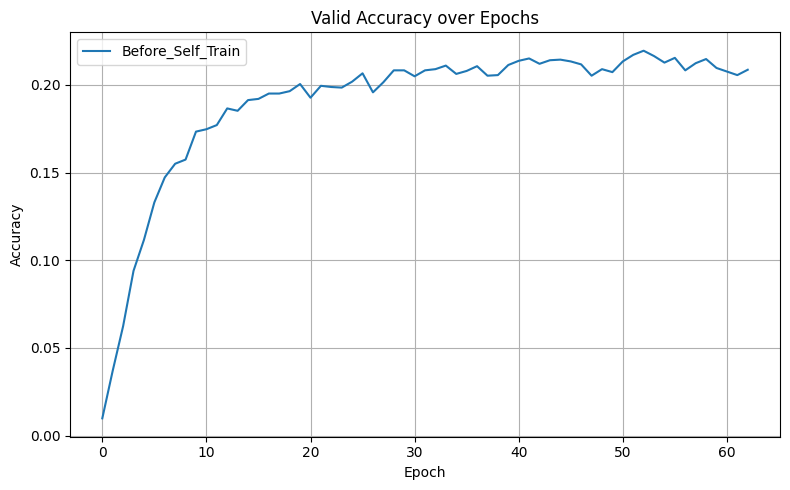

In [236]:
plot_results(results_dict, split="valid")

In [237]:
def predict_proba_from_emb(model, emb, batch_size=64, device="cuda"):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for i in range(0, emb.size(0), batch_size):
            batch_emb = emb[i:i+batch_size].to(device)  # (B, d_doc)
            logits = model(batch_emb)                  # (B, C)
            probs  = torch.sigmoid(logits)             # (B, C)
            all_probs.append(probs.cpu())
    return torch.cat(all_probs, dim=0)  # (N, C)

In [238]:
model.load_state_dict(best_model_state)  # 학습 끝난 최적 파라미터

model.eval()
probs_test = predict_proba_from_emb(model, test_emb, batch_size=64, device=device)

In [239]:
k = 3

# 1) 문서별 top-k (값 / 인덱스)
topk_vals, topk_idx = torch.topk(probs_test, k=k, dim=1)  # (N_test, k)

# 2) 그냥 그대로 리스트로 변환해서 사용
selected_indices_per_doc = topk_idx.tolist()  # 각 문서마다 top-3 클래스 인덱스
selected_scores_per_doc  = topk_vals.tolist() # 각 문서마다 top-3 점수

In [240]:
import os, csv
os.makedirs("/content/drive/MyDrive/BDA Project/outputs", exist_ok=True)

SUBMISSION_PATH = "/content/drive/MyDrive/BDA Project/outputs/(alibaba)path-core-mlp.csv"

test_ids = list(range(len(selected_indices_per_doc)))

def format_labels(label_indices):
    """
    label_indices: [int, int, ...]
    return: "라벨1, 라벨2, 라벨3" 형태의 문자열
    """
    if len(label_indices) == 0:
        return ""
    return ",".join(str(idx) for idx in label_indices)

# 각 문서별로 "라벨1, 라벨2, 라벨3" 형태의 문자열 만들기
labels_str_list = [format_labels(idxs) for idxs in selected_indices_per_doc]

# id / labels DataFrame 생성
pred_df = pd.DataFrame({
    "id": test_ids,
    "labels": labels_str_list,
})

pred_df.to_csv(SUBMISSION_PATH, index=False, encoding="utf-8-sig")

print(f"Saved predictions to {SUBMISSION_PATH}")

Saved predictions to /content/drive/MyDrive/BDA Project/outputs/(alibaba)path-core-mlp.csv


## Self Training